In [95]:
%pip install -q huggingface_hub open_clip_torch contextily stactools

Note: you may need to restart the kernel to use updated packages.


In [1]:
%%capture
%env AWS_REQUEST_PAYER=requester

---

In [52]:
from os.path import join
from glob import glob
import gc

from rastervision.pipeline.file_system.utils import (
    file_exists, file_to_json, json_to_file, list_paths)
from rastervision.core.box import Box
from rastervision.core.data import (
    geoms_to_geojson, RasterioSource, RasterioCRSTransformer, Scene)
from rastervision.core.data.utils import (geoms_to_geojson)
from rastervision.core.data.raster_source.stac_config import subset_assets
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm, trange
import albumentations as A
import numpy as np
import torch
from torch.utils.data import ConcatDataset, DataLoader
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()
import contextily as cx

import pystac_client
from pystac import ItemCollection
from shapely.geometry import mapping, shape, Point
import geopandas as gpd
import rasterio as rio

In [4]:
df = gpd.read_file('data/us-states.json')
df_aoi = df[df.name == 'Massachusetts']
# df_aoi = df[df.name == 'Pennsylvania']

In [10]:
aoi = df_aoi.geometry.unary_union.simplify(0)
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
items = catalog.search(
    intersects=mapping(aoi),
    collections=['naip'],
    datetime='2021-01-01/2021-12-31',
).item_collection()
len(items)

758

In [11]:
json_to_file(items.to_dict(), 'data/stac_items_naip_MA.json')

In [12]:
items = ItemCollection.from_file('data/stac_items_naip_MA.json')

In [17]:
df_items = gpd.GeoDataFrame.from_features(items)

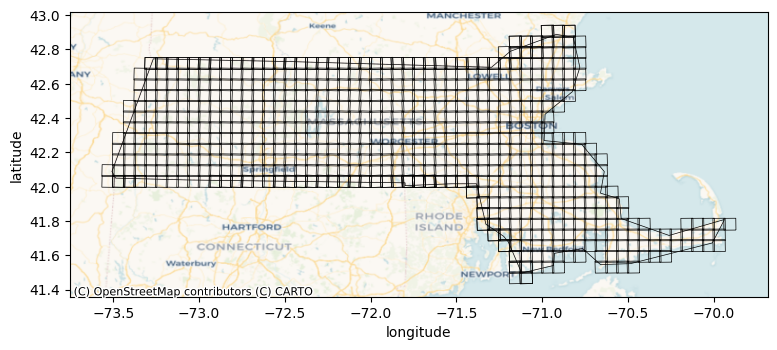

In [67]:
plt.close('all')
fig, ax = plt.subplots(figsize=(9, 5))
df_aoi.plot(ax=ax, ec='k', fc='none', lw=0.5)
df_items.plot(ax=ax, ec='k', fc='none', lw=0.5)
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

---

In [28]:
# uris = [item.assets['image'].href for item in items]

In [29]:
!aws s3 ls s3://raster-vision-ahassan/naip/2021_MA/

                           PRE 41069/
                           PRE 41070/
                           PRE 41071/
                           PRE 42070/
                           PRE 42071/
                           PRE 42072/
                           PRE 42073/


In [31]:
img_dirs = list_paths('s3://raster-vision-ahassan/naip/2021_MA/')
uris = sum((list_paths(d, ext='tif') for d in img_dirs), [])
len(uris)

INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv


742

In [53]:
df_items[df_items.intersects(Point(-71.1, 42.35))]

,geometry,naip:state,naip:year,gsd,proj:epsg,proj:shape,proj:bbox,proj:transform,proj:centroid,grid:code,storage:platform,storage:region,storage:requester_pays,earthsearch:payload_id,datetime,processing:software,created,updated
646,"POLYGON ((-71.05624 42.3104, -71.05848 42.3789...",ma,2021,0.6,26919,"[12687, 9932]","[324574.2, 4686288, 330533.4, 4693900.2]","[0.6, 0, 324574.2, 0, -0.6, 4693900.2, 0, 0, 1]","{'lat': 42.344, 'lon': -71.09351}",DOQQ-4207148NW,AWS,us-west-2,True,roda-naip/workflow-naip-to-stac/4c499a8affb3a3...,2021-08-26T16:00:00Z,{'naip-to-stac': '2023.05.22'},2023-05-22T19:00:50.559Z,2023-05-24T16:04:59.015Z


In [59]:
[i for i, uri in enumerate(uris) if uri.endswith('42071/m_4207148_nw_19_060_20210826.tif')]

[398]

In [69]:
rs = RasterioSource(uris[398], channel_order=[0, 1, 2], allow_streaming=False)

2024-08-28 14:28:11:rastervision.pipeline.file_system.utils: INFO - Downloading s3://raster-vision-ahassan/naip/2021_MA/42071/m_4207148_nw_19_060_20210826.tif to /opt/data/tmp/cache/s3/raster-vision-ahassan/naip/2021_MA/42071/m_4207148_nw_19_060_20210826.tif...
INFO:rastervision.pipeline.file_system.utils:Downloading s3://raster-vision-ahassan/naip/2021_MA/42071/m_4207148_nw_19_060_20210826.tif to /opt/data/tmp/cache/s3/raster-vision-ahassan/naip/2021_MA/42071/m_4207148_nw_19_060_20210826.tif...
INFO:botocore.tokens:Loading cached SSO token for rv


Downloading:  40%|####      | 191M/476M [00:05<00:07, 40.0MB/s]

In [106]:
np.array(densify_by_factor(rs.bbox.to_points(), 2))

array([[    0. ,     0. ],
       [    0. ,  6343.5],
       [    0. , 12687. ],
       [ 4966. , 12687. ],
       [ 9932. , 12687. ],
       [ 9932. ,  6343.5],
       [ 9932. ,     0. ]])

In [122]:
rs_bbox = rs.crs_transformer.pixel_to_map(rs.bbox)

In [120]:
rs_bbox_pixel = np.array(densify_by_factor(rs.bbox.to_points(), 2))
rs_bbox = np.vstack(rs.crs_transformer.pixel_to_map((rs_bbox_pixel[:, 0], rs_bbox_pixel[:, 1]))).T
rs_bbox

array([[-71.13081249,  42.3775876 ],
       [-71.12965499,  42.34333592],
       [-71.12849932,  42.30907861],
       [-71.09237037,  42.30974381],
       [-71.05624021,  42.31039763],
       [-71.05735672,  42.34465652],
       [-71.05847499,  42.37890977]])

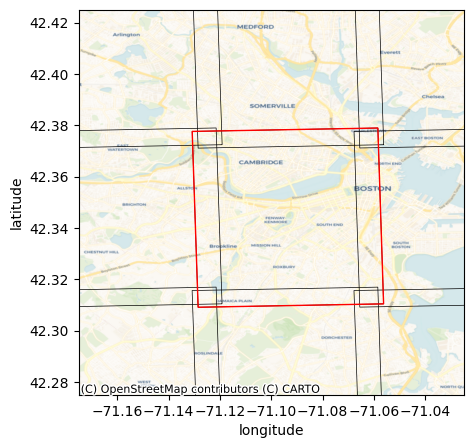

In [121]:
plt.close('all')
fig, ax = plt.subplots(figsize=(5, 5))
df_aoi.plot(ax=ax, ec='k', fc='none', lw=0.5)
df_items.plot(ax=ax, ec='k', fc='none', lw=0.5)
ax.add_patch(patches.Polygon(rs_bbox, ec='r', fc='none'))
ax.set_xlim((-71.175, -71.025))
ax.set_ylim((42.275, 42.425))
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [137]:
img = rs[:, :]
img.shape

(12687, 9932, 3)

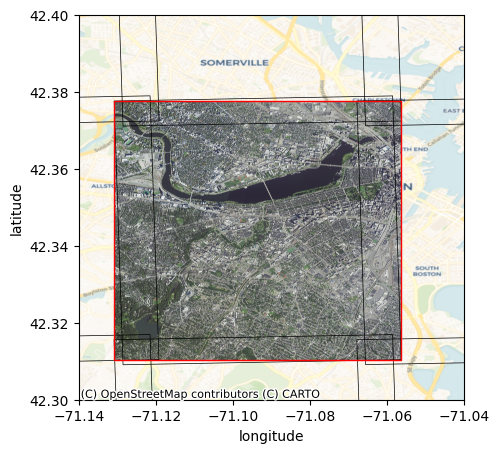

In [78]:
plt.close('all')
fig, ax = plt.subplots(figsize=(5, 5))
df_aoi.plot(ax=ax, ec='k', fc='none', lw=0.5)
df_items.plot(ax=ax, ec='k', fc='none', lw=0.5)
ax.add_patch(patches.Polygon(.to_points(), ec='r', fc='none'))
ax.set_xlim((-71.14, -71.04))
ax.set_ylim((42.3, 42.4))
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.imshow(img, extent=(rs_bbox.xmin, rs_bbox.xmax, rs_bbox.ymin, rs_bbox.ymax))
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

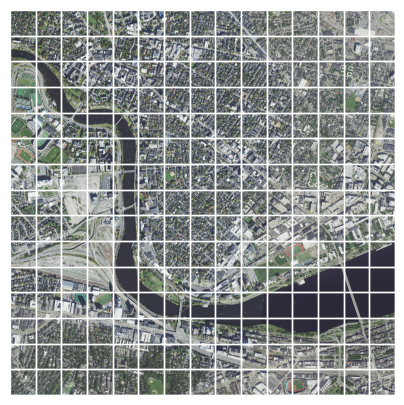

In [142]:
plt.close('all')
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img)
for w in rs.extent.get_windows(400, 400, padding=200):
    w_patch = patches.Polygon(w.to_points(), ec='w', fc='none', lw=1)
    ax.add_patch(w_patch)
ax.axis('off')
ax.set_xlim((0, 6000))
ax.set_ylim((0, 6000))
ax.invert_yaxis()
plt.show()

In [7]:
raster_sources = [
    RasterioSource(uri, channel_order=[0, 1, 2], allow_streaming=True) 
    for uri in tqdm(uris, desc='Initializing RasterSources')
]

Initializing RasterSources:   0%|          | 0/742 [00:00<?, ?it/s]

In [ ]:
# dses = [None] * len(raster_sources)
# for i, rs in enumerate(tqdm(raster_sources, desc='Initializing datasets')):
#     scene = Scene('', raster_source=rs)
#     ds = SemanticSegmentationSlidingWindowGeoDataset(
#         scene,
#         size=400,
#         stride=400,
#         padding=0,
#         transform=A.Resize(224, 224),
#     )
#     dses[i] = ds

In [14]:
# ds = ConcatDataset(dses)
# dl = DataLoader(ds, batch_size=16, num_workers=4)
# len(ds), len(dl)

(563379, 35212)

In [3]:
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_400_400.json naip_MA_400_400.json
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_800_800.json naip_MA_800_800.json
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_1600_1600.json naip_MA_1600_1600.json

download: s3://raster-vision-ahassan/naip/naip_MA_800_800.json to ./naip_MA_800_800.json
download: s3://raster-vision-ahassan/naip/naip_MA_1600_1600.json to ./naip_MA_1600_1600.json


In [8]:
# all_windows_df_400 = gpd.read_file('naip_MA_400_400.json')
# all_windows_df_800 = gpd.read_file('naip_MA_800_800.json')
all_windows_df_1600 = gpd.read_file('naip_MA_1600_1600.json')

In [9]:
rs_extents = [rs.crs_transformer.pixel_to_map(rs.bbox).to_shapely() for rs in raster_sources]
rs_df = gpd.GeoDataFrame(dict(rs_idx=range(len(raster_sources))), geometry=rs_extents)

---

In [10]:
from os.path import join

from huggingface_hub import hf_hub_download
import torch, open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [11]:
ckpt_path = 'SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]:v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.eval()

---

In [220]:
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_800_800.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt .

download: s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt to ./skyscript_naip_MA_1600_1600.pt


In [10]:
# embs_400 = torch.load('skyscript_naip_MA_400_400.pt')
# embs_800 = torch.load('skyscript_naip_MA_800_800.pt')
embs_1600 = torch.load('skyscript_naip_MA_1600_1600.pt')
# embs_400.shape, embs_800.shape, embs_1600.shape

In [11]:
def chip_idx_to_chip(i, all_windows_df, out_shape):
    window_map = chip_idx_to_map_window(i, all_windows_df)
    rs = map_window_to_raster_source(window_map)
    crs_tf = rs.crs_transformer
    window_pixel = Box.from_shapely(crs_tf.map_to_pixel(window_map)).to_int()
    chip = rs.get_chip(window_pixel, out_shape=out_shape)
    return chip
    
def chip_idx_to_map_window(i, all_windows_df):
    i = int(i)
    window_map = all_windows_df.iloc[i].item()
    return window_map
    
def map_window_to_raster_source(window_map):
    matched_rs_inds = rs_df[rs_df.intersects(window_map)].rs_idx.tolist()
    if len(matched_rs_inds) == 0:
        print(window_map)
        assert False
    matched_rses = [raster_sources[i] for i in matched_rs_inds]
    crs_tfs = [rs.crs_transformer for rs in matched_rses]
    windows_pixel = [
        Box.from_shapely(crs_tf.map_to_pixel(window_map)).to_int()
        for crs_tf in crs_tfs
    ]
    intersections = [
        rs.bbox.intersection(w).area for rs, w in zip(matched_rses, windows_pixel)]
    best_match_idx = np.argmax(intersections)
    rs = matched_rses[best_match_idx]
    return rs

---

In [21]:
N = len(embs_400)
embs_idx_to_uri_400 = [None] * N
embs_idx_to_window_400 = [None] * N
for i in trange(N):
    w = chip_idx_to_map_window(i, all_windows_df_400)
    rs = map_window_to_raster_source(w)
    embs_idx_to_window_400[i] = w
    embs_idx_to_uri_400[i] = rs.uris[0]

  0%|          | 0/563379 [00:00<?, ?it/s]

In [23]:
properties_400 = [dict(uri=uri, emb_idx=i) for i, uri in enumerate(embs_idx_to_uri_400)]
geojson_400 = geoms_to_geojson(embs_idx_to_window_400, properties=properties_400)
json_to_file(geojson_400, 'naip_MA_400_400_w_uris.json')

Serializing geoms:  25%|##5       | 143599/563379 [00:05<00:14, 28719.67it/s]

In [41]:
!aws s3 cp naip_MA_400_400_w_uris.json s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json

upload: ./naip_MA_400_400_w_uris.json to s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json


---

In [24]:
N = len(embs_800)
embs_idx_to_uri_800 = [None] * N
embs_idx_to_window_800 = [None] * N
for i in trange(N):
    w = chip_idx_to_map_window(i, all_windows_df_800)
    rs = map_window_to_raster_source(w)
    embs_idx_to_window_800[i] = w
    embs_idx_to_uri_800[i] = rs.uris[0]

  0%|          | 0/137616 [00:00<?, ?it/s]

In [25]:
properties_800 = [dict(uri=uri, emb_idx=i) for i, uri in enumerate(embs_idx_to_uri_800)]
geojson_800 = geoms_to_geojson(embs_idx_to_window_800, properties=properties_800)
json_to_file(geojson_800, 'naip_MA_800_800_w_uris.json')

In [42]:
!aws s3 cp naip_MA_800_800_w_uris.json s3://raster-vision-ahassan/naip/naip_MA_800_800_w_uris.json

upload: ./naip_MA_800_800_w_uris.json to s3://raster-vision-ahassan/naip/naip_MA_800_800_w_uris.json


---

In [12]:
N = len(embs_1600)
embs_idx_to_uri_1600 = [None] * N
embs_idx_to_window_1600 = [None] * N
for i in trange(N):
    w = chip_idx_to_map_window(i, all_windows_df_1600)
    rs = map_window_to_raster_source(w)
    embs_idx_to_window_1600[i] = w
    embs_idx_to_uri_1600[i] = rs.uris[0]

  0%|          | 0/33192 [00:00<?, ?it/s]

In [13]:
properties_1600 = [dict(uri=uri, emb_idx=i) for i, uri in enumerate(embs_idx_to_uri_1600)]
geojson_1600 = geoms_to_geojson(embs_idx_to_window_1600, properties=properties_1600)
json_to_file(geojson_1600, 'naip_MA_1600_1600_w_uris.json')

In [14]:
!aws s3 cp naip_MA_1600_1600_w_uris.json s3://raster-vision-ahassan/naip/naip_MA_1600_1600_w_uris.json

upload: ./naip_MA_1600_1600_w_uris.json to s3://raster-vision-ahassan/naip/naip_MA_1600_1600_w_uris.json


---

In [14]:
def show_top_chips(chip_scores, all_windows_df, top_inds=None, nrows=5, ncols=5, figsize=(12, 12), w_pad=-2.5, h_pad=-2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, i in zip(tqdm(axs.flat), top_inds):
        chip = chip_idx_to_chip(i, all_windows_df)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

In [15]:
def get_chip_scores(text_queries, embs):
    text = tokenizer(text_queries)
    with torch.inference_mode():
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu()
        chip_scores = torch.cosine_similarity(text_features, embs)
    return chip_scores

In [16]:
text_queries = [
    # 'trees',
    # 'crop fields',
    # 'river',
    # 'barren land',
    # 'a long bridge over a large body of water',
    # 'a large ship',
    # 'a large parking lot',
    # 'airport',
    # 'stadium',
    # 'warehouses',
    # 'storage tanks',
    # 'power plant',
    # 'house with swimming pool',
    'a single tree in an empty field',
    # 'a large solar farm',
    # 'lots of cars',
    # 'a single tennis court',
    
]
chip_scores_400 = get_chip_scores(text_queries, embs_400)
# chip_scores_800 = get_chip_scores(text_queries, embs_800)

In [ ]:
text_queries = [
    'a long bridge over a large body of water',
    
]
chip_scores_400 = get_chip_scores(text_queries, embs_400)
show_top_chips(chip_scores_400, all_windows_df_400, nrows=2, ncols=4, figsize=(12, 6), w_pad=-(12/4), h_pad=-(6/4))
chip_scores_800 = get_chip_scores(text_queries, embs_800)
show_top_chips(chip_scores_800, all_windows_df_800, nrows=2, ncols=4, figsize=(12, 6), w_pad=-(12/4), h_pad=-(6/4))
chip_scores_1600 = get_chip_scores(text_queries, embs_1600)
show_top_chips(chip_scores_1600, all_windows_df_1600, nrows=2, ncols=4, figsize=(12, 6), w_pad=-(12/4), h_pad=-(6/4))

---

In [ ]:
(chip_scores > 0.225).sum()

In [ ]:
plt.hist(chip_scores, bins=100)
# plt.yscale('symlog')
plt.show()

---

In [ ]:
!mamba install ffmpeg -y

In [17]:
from skimage.transform import resize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib import animation, patches, patheffects

In [243]:
all_windows_df = all_windows_df_800
chip_scores = chip_scores_800

In [244]:
n_matches = 100
n_imgs = 3
top_inds = torch.topk(chip_scores, n_matches * 2).indices

matched_windows_df = all_windows_df.iloc[top_inds]
within_aoi_mask = matched_windows_df.within(df_aoi.unary_union).to_numpy()
matched_windows_df = matched_windows_df[within_aoi_mask]

top_inds = top_inds[within_aoi_mask][:n_matches]
matched_windows_df = matched_windows_df.iloc[:n_matches]

img_inds = top_inds[:n_imgs]
imgs = [chip_idx_to_chip(i, all_windows_df) for i in tqdm(img_inds)]
locs = matched_windows_df.iloc[:n_imgs].centroid

  0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
imgs = [resize(img[100:-100, 100:-100], (400, 400)) for img in imgs]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim((-74.45, -69.75))
ax.set_ylim((41.25, 43))
# ax.axis('off')

df_aoi.plot(ax=ax, ec='gray', fc='none')
matched_windows_df.centroid.plot(ax=ax, c='steelblue', markersize=16)

# img_offsets = [(-230, 60), (240, 90), (-70, -100)]
# arcs = [-0.3, -0.1, 0.5]
img_offsets = [(-130, -100), (240, 90), (50, -100)]
arcs = [-0.3, -0.1, 0.2]
for img, loc, offset, arcrad in zip(imgs, locs, img_offsets, arcs):
    imagebox = OffsetImage(img, zoom=0.3)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (loc.x, loc.y),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="-",
                            shrinkA=4,
                            shrinkB=4,
                            connectionstyle=f'arc3,rad={arcrad}',
                            ec='#111',
                        )
        )
    ax.add_artist(ab)
plt.show()

---

In [18]:
def get_img_inds_and_locs(chip_scores, all_windows_df, n_matches=100, n_imgs=3):
    top_inds = torch.topk(chip_scores, n_matches * 2).indices
    
    matched_windows_df = all_windows_df.iloc[top_inds]
    within_aoi_mask = matched_windows_df.within(df_aoi.unary_union).to_numpy()
    matched_windows_df = matched_windows_df[within_aoi_mask]
    
    top_inds = top_inds[within_aoi_mask][:n_matches]
    matched_windows_df = matched_windows_df.iloc[:n_matches]
    
    img_inds = top_inds[:n_imgs]
    locs = matched_windows_df.iloc[:n_imgs].centroid

    return img_inds, locs, matched_windows_df

In [23]:
img_inds_sp, locs_sp, matched_windows_df_sp = get_img_inds_and_locs(chip_scores_400, all_windows_df_400)
img_inds_sp, locs_sp

(tensor([126703, 127692, 544365]),
 126703    POINT (-71.92101 42.61189)
 127692    POINT (-71.78045 42.34064)
 544365    POINT (-70.70023 42.07333)
 dtype: geometry)

In [19]:
img_inds_tree, locs_tree, matched_windows_df_tree = get_img_inds_and_locs(chip_scores_400, all_windows_df_400)
img_inds_tree, locs_tree

(tensor([318170, 405212, 121997]),
 318170    POINT (-73.16575 42.68811)
 405212    POINT (-72.43781 42.27497)
 121997    POINT (-71.23748 42.62286)
 dtype: geometry)

In [27]:
img_inds_solar, locs_solar, matched_windows_df_solar = get_img_inds_and_locs(chip_scores_800, all_windows_df_800)
img_inds_solar, locs_solar

(tensor([102515,   2760,  90981]),
 102515    POINT (-72.31231 42.17557)
 2760      POINT (-72.00122 42.07363)
 90981     POINT (-72.19913 42.17154)
 dtype: geometry)

In [28]:
imgs_tree = [chip_idx_to_chip(i, all_windows_df_400) for i in img_inds_tree]
imgs_sp = [resize(chip_idx_to_chip(i, all_windows_df_400)[100:-100, 100:-100], (400, 400)) for i in img_inds_sp]
imgs_solar = [chip_idx_to_chip(i, all_windows_df_800) for i in img_inds_solar]

In [97]:
queries = [
    dict(
        text='house with swimming pool',
        imgs=imgs_sp,
        locs=locs_sp,
        matched_windows_df=matched_windows_df_sp,
        img_offsets=[(-310, 0), (-70, -150), (60, 100)],
        arcs=[-0.3, -0.3, -0.4],
        color='steelblue',
    ),
    dict(
        text='a single tree in an empty field',
        imgs=imgs_tree,
        locs=locs_tree,
        matched_windows_df=matched_windows_df_tree,
        img_offsets=[(-110, -20), (30, -130), (150, -30)],
        arcs=[-0.3, 0.3, -0.2],
        color='g',
    ),
    dict(
        text='a large solar farm',
        imgs=imgs_solar,
        locs=locs_solar,
        matched_windows_df=matched_windows_df_solar,
        img_offsets=[(-130, -110), (280, 100), (60, -110)],
        arcs=[-0.3, -0.1, 0.1],
        color='gray',
    ),
]

In [20]:
imgs_tree = [chip_idx_to_chip(i, all_windows_df_400) for i in img_inds_tree]

In [22]:
queries = [
    dict(
        text='a single tree in an empty field',
        imgs=imgs_tree,
        locs=locs_tree,
        matched_windows_df=matched_windows_df_tree,
        img_offsets=[(-110, -20), (30, -130), (150, -30)],
        arcs=[-0.3, 0.3, -0.2],
        color='g',
    ),
]

In [ ]:
plt.close('all')

max_text_len = 40

query = queries[0]
search_query = query['text']
matched_windows_df = query['matched_windows_df']
imgs = query['imgs']
locs = query['locs']
img_offsets = query['img_offsets']
arcs = query['arcs']
color = query['color']

fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)

df_aoi.plot(ax=ax, ec='gray', fc='none')
ax.set_xlim((-74.2, -69.85))
ax.set_ylim((41.4, 43.15))
ax.axis('off')

search_query += ' ' * max(0, max_text_len - len(search_query))
text_artist = ax.text(0.225, 0.94, search_query, 
        color='black', 
        fontfamily='monospace',
        fontsize=14,
        bbox=dict(
            facecolor='none', 
            edgecolor='#333', 
            lw=1.5,
            boxstyle='round,pad=1', 
            path_effects=[patheffects.SimpleLineShadow((0, -1.5)), patheffects.Normal()],
        ),
        transform=ax.transAxes)
ax.scatter(matched_windows_df.centroid.x, matched_windows_df.centroid.y, c=color, s=16)

for img, loc, offset, arcrad in zip(imgs, locs, img_offsets, arcs):
    ax.scatter([loc.x], [loc.y], s=32, fc='none', ec='k', lw=2)
    imagebox = OffsetImage(img, zoom=0.3)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (loc.x, loc.y),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="-",
                            shrinkA=4,
                            shrinkB=8,
                            connectionstyle=f'arc3,rad={arcrad}',
                            ec='#111',
                        ))
    ax.add_artist(ab)
plt.show()

In [45]:
fig.savefig('qe_naip_tree.png', bbox_inches='tight', pad_inches=0.2, transparent=False)

In [ ]:
plt.close('all')
try: del fig
except: pass

max_text_len = 40

fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)

def data_gen():
    for q in queries:
        for data in data_gen_query(q):
            yield data
    
def data_gen_query(query):
    text = query['text']
    matched_windows_df = query['matched_windows_df']
    imgs = query['imgs']
    locs = query['locs']
    img_offsets = query['img_offsets']
    arcs = query['arcs']
    color = query['color']
    for i in range(len(text) + 1):
        if i == len(text):
            out = text
        else:
            out = text[:i] + '|'
        out += ' ' * max(0, max_text_len - len(out))
        yield out
    for i in range(1, len(matched_windows_df), 5):
        yield matched_windows_df.iloc[:i], dict(c=color, s=16)
    for data in zip(imgs, locs, img_offsets, arcs):
        yield data
        for _ in range(10):
            yield None
    for _ in range(40):
        yield None
    for i in range(len(text) + 1, -1, -1):
        if i == len(text):
            out = text
        else:
            out = text[:i] + '|'
        out += ' ' * max(0, max_text_len - len(out))
        yield out
    yield 'clear'

def draw_base():
    df_aoi.plot(ax=ax, ec='gray', fc='none')
    ax.set_xlim((-74.2, -69.75))
    ax.set_ylim((41.25, 43.15))
    ax.axis('off')

def init():
    draw_base()
    return [ax]

def draw(data):
    # draw_base()
    if isinstance(data, str):
        if data == 'clear':
            ax.clear()
            draw_base()
        else:
            ax.clear()
            draw_base()
            search_query = data
            text_artist = ax.text(0.225, 0.94, search_query, 
                    color='black', 
                    fontfamily='monospace',
                    fontsize=14,
                    bbox=dict(
                        facecolor='none', 
                        edgecolor='#333', 
                        lw=1.5,
                        boxstyle='round,pad=1', 
                        path_effects=[patheffects.SimpleLineShadow((0, -1.5)), patheffects.Normal()],
                    ),
                    transform=ax.transAxes)
    elif isinstance(data, tuple):
        if len(data) == 2:
            df, args = data
            ax.scatter(df.centroid.x, df.centroid.y, **args)
        elif len(data) == 4:
            img, loc, offset, arcrad = data
            ax.scatter([loc.x], [loc.y], s=32, fc='none', ec='k', lw=2)
            imagebox = OffsetImage(img, zoom=0.3)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, (loc.x, loc.y),
                                xybox=offset,
                                xycoords='data',
                                boxcoords='offset points',
                                frameon=False,
                                arrowprops=dict(
                                    arrowstyle="-",
                                    shrinkA=4,
                                    shrinkB=8,
                                    connectionstyle=f'arc3,rad={arcrad}',
                                    ec='#111',
                                ))
            ax.add_artist(ab)
    return [ax]

anim = animation.FuncAnimation(fig, draw, data_gen, init_func=init, interval=(1/20)*1000, blit=False)
# anim.save('anim_qe_MA_pool.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))
# anim.save('anim_qe_MA_tree.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))
# anim.save('anim_qe_MA_solar.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))
anim.save('anim_qe2.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))

---

In [51]:
def loc_to_gmaps_url(loc):
    return f'https://www.google.com/maps/@{loc.y},{loc.x},220m/data=!3m1!1e3'

['https://www.google.com/maps/@42.61189476868027,-71.9210074955092,220m/data=!3m1!1e3',
 'https://www.google.com/maps/@42.34064250969053,-71.78045435917868,220m/data=!3m1!1e3',
 'https://www.google.com/maps/@42.07332902993591,-70.70023158114142,220m/data=!3m1!1e3']

In [333]:
print([loc_to_gmaps_url(loc) for loc in locs_sp.tolist()])
print([loc_to_gmaps_url(loc) for loc in locs_tree.tolist()])
print([loc_to_gmaps_url(loc) for loc in locs_solar.tolist()])

['https://www.google.com/maps/@42.61189476868027,-71.9210074955092,220m/data=!3m1!1e3', 'https://www.google.com/maps/@42.34064250969053,-71.78045435917868,220m/data=!3m1!1e3', 'https://www.google.com/maps/@42.07332902993591,-70.70023158114142,220m/data=!3m1!1e3']
['https://www.google.com/maps/@42.688114949419315,-73.16574830170984,220m/data=!3m1!1e3', 'https://www.google.com/maps/@42.274970919890094,-72.43781014498711,220m/data=!3m1!1e3', 'https://www.google.com/maps/@42.62286280533239,-71.23747547326747,220m/data=!3m1!1e3']
['https://www.google.com/maps/@42.175573653204644,-72.31231035901423,220m/data=!3m1!1e3', 'https://www.google.com/maps/@42.073633476804545,-72.00121752147678,220m/data=!3m1!1e3', 'https://www.google.com/maps/@42.171540581029014,-72.19913362478538,220m/data=!3m1!1e3']


---

In [85]:
n_imgs = 3
n_matches = 8

img_inds_400 = torch.topk(chip_scores_400, n_matches).indices[:n_imgs]
imgs_400 = [chip_idx_to_chip(i, all_windows_df_400) for i in tqdm(img_inds_400)]

img_inds_800 = torch.topk(chip_scores_800, n_matches).indices[:n_imgs]
imgs_800 = [chip_idx_to_chip(i, all_windows_df_800) for i in tqdm(img_inds_800)]

img_inds_1600 = torch.topk(chip_scores_1600, n_matches).indices[[0, 1, 7]]
imgs_1600 = [chip_idx_to_chip(i, all_windows_df_1600) for i in tqdm(img_inds_1600)]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
fig.tight_layout(h_pad=-3, w_pad=-0.5)
fig.subplots_adjust(top=0.92)
fig.suptitle('"a long bridge over a large body of water"', fontsize=14)
for axs_col, imgs, title in zip(axs.T, [imgs_400, imgs_800, imgs_1600], ['400x400 chips', '800x800 chips', '1600x1600 chips']):
    axs_col[0].set_title(title)
    for ax, img in zip(axs_col, imgs):
        ax.imshow(img)
        ax.axis('off')
plt.show()

In [89]:
fig.savefig('qe_naip_chip_size.png', bbox_inches='tight', pad_inches=0.2)